## Imports

In [1]:

from sklearn.metrics import  confusion_matrix
import spacy
import nltk
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import shap
import re
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.svm import SVR
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
random_seed = 42
from xgboost import XGBClassifier
tqdm.pandas()
import scipy.stats as st


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## data

### read

In [2]:
df_features = pd.read_csv('../data/processed/processed_dataset.csv')
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,...,child_lemma,child_pos,child_tag,child_shape,child_is_alpha,child_is_stop,child_morph,child_ner,child_ner_start_end,parent_ner_start_end
0,sci,1,ter,person,:ARG0,nsubj,tem,ter,VERB,VERB,...,Meyer,PROPN,PROPN,Xxxxx,True,False,Gender=Masc|Number=Sing,PER,"[0, 1]",NaN
1,sci,4,fazer,isso,:ARG1,nao_tem_dep,feito,fazer,VERB,VERB,...,isso,PRON,PRON,Xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
2,sci,4,fazer,universidade,:ARG3,obl,feito,fazer,VERB,VERB,...,universidade,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN
3,sci,12,acontecer,isso,:ARG1,nsubj,acontece,acontecer,VERB,VERB,...,isso,PRON,PRON,xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
4,sci,16,entender,otimista,:ARG0,nsubj,entendem,entender,VERB,VERB,...,otimista,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Plur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,PropBankBr_v1.1_Dep,propbank_3347,ser,Abram_Szajman,ARG1,nao_tem_dep,é,ser,AUX,AUX,...,Abram_Szajman,PROPN,PROPN,Xxxxx_Xxxxx,False,False,Gender=Masc|Number=Sing,LOC,"[0, 1]",NaN
13242,PropBankBr_v1.1_Dep,propbank_3347,ser,presidente,ARG2,ROOT,é,ser,AUX,AUX,...,presidente,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Sing,NaN,NaN,NaN
13243,PropBankBr_v1.1_Dep,propbank_3348,surpreender,que,ARG0,nsubj,surpreendeu,surpreender,VERB,VERB,...,que,PRON,PRON,xxx,True,True,Gender=Masc|Number=Sing|PronType=Rel,NaN,NaN,NaN
13244,PropBankBr_v1.1_Dep,propbank_3348,surpreender,galera,ARG1,obj,surpreendeu,surpreender,VERB,VERB,...,galera,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN


### drop useless columns

In [3]:
# dropa colunas inuteis
df_features = df_features.drop(['parent_shape',
       'parent_is_alpha', 'parent_is_stop', 'parent_morph', 'child_shape',
       'child_is_alpha', 'child_is_stop', 'child_morph', 
       'child_ner_start_end', 'parent_ner_start_end'],axis = 1)

df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner'],
      dtype='object')

### Fill nan values

In [4]:
df_features.isna().sum()

corpus_name         0
id                  0
parent              0
child               0
label               0
dep                 0
parent_text         0
parent_lemma        0
parent_pos          0
parent_tag          0
parent_ner      13148
child_text          0
child_lemma         0
child_pos           0
child_tag           0
child_ner       11989
dtype: int64

In [5]:
df_features.groupby('corpus_name').apply(lambda x: x.isna().sum())

/tmp/ipykernel_4051178/2542205653.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features.groupby('corpus_name').apply(lambda x: x.isna().sum())


,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner
corpus_name,,,,,,,,,,,,,,,,
PropBankBr_v1.1_Dep,0,0,0,0,0,0,0,0,0,0,10113,0,0,0,0,8982
lp,0,0,0,0,0,0,0,0,0,0,1587,0,0,0,0,1572
news,0,0,0,0,0,0,0,0,0,0,983,0,0,0,0,981
opisums,0,0,0,0,0,0,0,0,0,0,373,0,0,0,0,366
sci,0,0,0,0,0,0,0,0,0,0,92,0,0,0,0,88


In [6]:
### all nan to nsa (nao se aplica)
df_features.fillna('nsa', inplace = True)

### transform and create label

In [7]:
df_features.label.value_counts()

label
ARG1         5440
ARG0         3057
:ARG1        1517
ARG2         1413
:ARG0        1033
:ARG2         296
ARG3          151
ARG4          114
:ARG1-of       95
:ARG0-of       63
:ARG3          37
:ARG4          23
:ARG2-of        5
:ARG01-of       1
ARG5            1
Name: count, dtype: int64

In [8]:
# ################################
# # Completo 
# ################################

df_features['label'] = df_features.label.apply(
    lambda x: 
        0 if "arg0" in x.casefold() else
        1 if "arg1" in x.casefold() else
        2 if "arg2" in x.casefold() else
        3 if "arg3" in x.casefold() else
        4 if "arg4" in x.casefold() else
     #   5 if "arg5" in x.casefold() else
        "erro"
        
)

df_features['label'].value_counts()

df_features = df_features[
    (df_features.label != 'erro')]
df_features.label.value_counts()

label
1    7052
0    4154
2    1714
3     188
4     137
Name: count, dtype: int64

In [9]:
df_features.groupby(['corpus_name', 'label']).size()

corpus_name          label
PropBankBr_v1.1_Dep  0        3057
                     1        5440
                     2        1413
                     3         151
                     4         114
lp                   0         642
                     1         807
                     2         111
                     3          16
                     4          12
news                 0         299
                     1         560
                     2         131
                     3          13
                     4          10
opisums              0         132
                     1         196
                     2          44
                     3           5
sci                  0          24
                     1          49
                     2          15
                     3           3
                     4           1
dtype: int64

In [10]:
df_features.label = df_features.label.astype('int')

In [11]:
df_features['stratify-column'] = df_features.apply(lambda x: str(x.corpus_name) + "_" + str(x.label), axis = 1)
df_features['stratify-column']

0                        sci_0
1                        sci_1
2                        sci_3
3                        sci_1
4                        sci_0
                 ...          
13241    PropBankBr_v1.1_Dep_1
13242    PropBankBr_v1.1_Dep_2
13243    PropBankBr_v1.1_Dep_0
13244    PropBankBr_v1.1_Dep_1
13245    PropBankBr_v1.1_Dep_1
Name: stratify-column, Length: 13245, dtype: object

### features and label

In [12]:
# separa propbank que só vai no treino
propbank_index = df_features[df_features.corpus_name == "PropBankBr_v1.1_Dep"].index.tolist()

In [13]:
X = df_features.drop(['corpus_name', 'id', 'stratify-column', "label"], axis = 1)
y = df_features['label']

In [14]:
display(X.head())
display(y.head())

,parent,child,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner
0,ter,person,nsubj,tem,ter,VERB,VERB,nsa,Meyer,Meyer,PROPN,PROPN,PER
1,fazer,isso,nao_tem_dep,feito,fazer,VERB,VERB,nsa,Isso,isso,PRON,PRON,nsa
2,fazer,universidade,obl,feito,fazer,VERB,VERB,nsa,universidade,universidade,NOUN,NOUN,nsa
3,acontecer,isso,nsubj,acontece,acontecer,VERB,VERB,nsa,isso,isso,PRON,PRON,nsa
4,entender,otimista,nsubj,entendem,entender,VERB,VERB,nsa,otimistas,otimista,NOUN,NOUN,nsa


0    0
1    1
2    3
3    1
4    0
Name: label, dtype: int64

### col vectorization

In [15]:
# # Obter embeddings para as palavras em cada coluna
def get_embedding(word):
    
    # da pau quando nao tem a palavra
    try:
        return model[word]
    except Exception as e:
        return [-1000 for n in range(len_emb)] 

In [16]:
# carrega o modelo
len_emb= 300
## glove
#model = KeyedVectors.load_word2vec_format(f'../embeddings/glove_s{len_emb}.txt')
## cbow
model = KeyedVectors.load_word2vec_format(f'../embeddings/cbow_s{len_emb}.txt')

In [17]:
#######################################################
# Antigo: lemma
#######################################################
embeddings_parent = X['parent_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
embeddings_child = X['child_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X.index)

X.drop(['parent', 'parent_lemma', 'child', 'child_lemma'], axis=1, inplace = True)

cat_cols = [col for col in X.columns if "emb" not in col]
X_enc = pd.get_dummies(X[cat_cols])
X_enc

X_enc[[f"emb_{n}_lemma_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
X_enc[[f"emb_{n}_lemma_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X_enc.index)

100%|██████████| 13245/13245 [00:00<00:00, 669223.20it/s]
/tmp/ipykernel_4051178/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_4051178/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_4051178/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This 

In [18]:
print(len(X_enc[X_enc[f"emb_1_lemma_parent"] == -1000]))
print(len(X_enc[X_enc[f"emb_1_lemma_child"] == -1000]))

479
1454


### Train test split

In [19]:
###############################################
# train test split com o propbank só no treino
###############################################

# Separar os índices obrigatórios para treino
X_train_obrigatorio = X_enc.loc[propbank_index]
y_train_obrigatorio = y.loc[propbank_index]

# Índices restantes
X_restante = X_enc.drop(propbank_index)
y_restante = y.drop(propbank_index)

# Dividir o restante em treino e teste
X_train_restante, X_test, y_train_restante, y_test = train_test_split(X_restante, y_restante, test_size=0.2, random_state=42, stratify=df_features.drop(propbank_index)['label'])


# Combinar os dados de treino obrigatório com os dados de treino restante
X_train = pd.concat([X_train_restante, X_train_obrigatorio])
y_train = pd.concat([y_train_restante, y_train_obrigatorio])

In [20]:
# remover features que nao variam no treino
features_std_0 = X_train.columns[X_train.std() == 0].tolist()
X_train.drop(features_std_0,axis = 1, inplace=True)
X_test.drop(features_std_0,axis = 1, inplace=True)

## Classification

### Hyperparameter tunning

In [21]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [22]:
#selector = RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)
selector = SelectPercentile()
sampler = SMOTE(random_state=42)#None#RandomOverSampler(sampling_strategy='minority',random_state=random_seed)
scaler = StandardScaler()

estimator = XGBClassifier(
    device = 'cuda',
 #tree_method = 'hist',
#    sample_weights = sample_weights
    )

pipeline_steps = [
    ('scaling', scaler),
    ('selecting', selector),
    ('sampling', sampler),
    ('estimator',estimator)
    ] 



pipeline = Pipeline(steps = pipeline_steps)

In [23]:
n_classes = len(y_train.unique())

In [24]:
# Preconfigure estimator and parameters
params = {  
            "estimator__n_estimators": st.randint(3, 40),
            "estimator__max_depth": st.randint(3, 40),
            "estimator__learning_rate": st.uniform(0.05, 0.4),
            "estimator__colsample_bytree": st.beta(10, 1),
            "estimator__subsample": st.beta(10, 1),
            "estimator__gamma": st.uniform(0, 10),
            'estimator__objective': ['multi:softmax'],
            'estimator__eval_metric':['aucpr'],
            
            #'estimator__scale_pos_weight': st.randint(0, 2),
            "estimator__min_child_weight": st.expon(0, 50),
            "selecting__percentile": [10,25,40,50,80],
            "estimator__num_class": [n_classes]
            
            
        }

# Random Search Training with 5 folds Cross Validation
rf_random = RandomizedSearchCV(
    pipeline, 
    params, 
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), 
    verbose=4,
    n_iter=20, 
    random_state=42, 
    scoring='f1_macro') 
                              
rf_random.fit(X_train, y_train)  
best_params = rf_random.best_params_
best_score = rf_random.best_score_

print('best_params', best_params)
print('best_score', best_score)

model = rf_random.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.765 total time= 1.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.684 total time=  55.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.670 total time=  56.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.686 total time=  57.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.672 total time= 1.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.706 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.657 total time= 1.2min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.734 total time= 1.2min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.688 total time= 1.4min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.675 total time= 1.4min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.727 total time=  42.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.694 total time=  49.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.629 total time=  53.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.689 total time=  52.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.677 total time=  55.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.705 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.664 total time=  55.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.721 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.694 total time=  56.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.664 total time= 1.2min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.647 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.624 total time=  55.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.615 total time=  58.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.619 total time=  57.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.625 total time=  52.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.681 total time=  58.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.593 total time= 1.5min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.663 total time= 3.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.610 total time= 2.7min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.606 total time= 1.8min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.711 total time=  22.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.641 total time=  38.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.630 total time=  33.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.660 total time=  34.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.671 total time=  32.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.638 total time=  29.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.634 total time=  28.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.693 total time=  24.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.633 total time=  34.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.614 total time=  51.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.684 total time= 1.2min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.649 total time= 1.2min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.613 total time= 1.7min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.638 total time= 1.6min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.635 total time= 1.6min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.674 total time= 1.2min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.592 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.669 total time=  56.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.620 total time=  56.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.617 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.655 total time=  17.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.587 total time=  18.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.592 total time=  18.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.609 total time=  19.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.594 total time=  18.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.636 total time=  18.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.586 total time=  16.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.602 total time=  18.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.584 total time=  18.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.591 total time=  18.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.665 total time=  56.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.643 total time=  58.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.612 total time=  58.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.637 total time= 1.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.648 total time=  58.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.668 total time=  59.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.613 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.660 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.613 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.609 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.641 total time=  30.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.595 total time=  31.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.575 total time=  35.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.610 total time=  39.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.604 total time=  33.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.613 total time=  29.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.551 total time=  36.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.668 total time=  28.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.618 total time=  37.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.586 total time=  37.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.740 total time= 1.4min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.691 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.622 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.647 total time=  57.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.650 total time=  56.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.704 total time=  52.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.646 total time=  55.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.703 total time=  53.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.667 total time=  56.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.650 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.773 total time=  30.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.678 total time=  32.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.693 total time=  39.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.690 total time=  36.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.740 total time=  30.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.736 total time=  32.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.688 total time=  31.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.724 total time=  32.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.710 total time=  32.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.711 total time=  27.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.758 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.704 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.673 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.715 total time= 1.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.710 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.712 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.709 total time=  57.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.745 total time=  55.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.678 total time=  59.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.696 total time=  55.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.733 total time=  18.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.663 total time=  18.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.642 total time=  17.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.642 total time=  18.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.675 total time=  21.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.701 total time=  22.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.665 total time=  22.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.694 total time=  20.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.651 total time=  19.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.698 total time=  20.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.710 total time=  45.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.685 total time=  42.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.616 total time=  45.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.647 total time=  42.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.653 total time=  55.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.680 total time=  51.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.640 total time=  41.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.686 total time=  43.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.686 total time=  41.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.656 total time=  43.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.654 total time=  30.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.642 total time=  28.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.591 total time=  31.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.610 total time=  27.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.625 total time=  29.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.648 total time=  31.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.598 total time=  32.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.682 total time=  33.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.621 total time=  29.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.620 total time=  33.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.697 total time= 2.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.662 total time= 2.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.586 total time= 2.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.650 total time= 2.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.639 total time= 2.6min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.649 total time= 2.7min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.616 total time= 2.6min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.656 total time= 2.4min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.662 total time= 1.8min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.631 total time= 1.4min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  37.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  34.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  31.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  34.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  32.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  35.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  36.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  35.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  39.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=nan total time=  39.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.756 total time= 2.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.673 total time= 2.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.645 total time= 1.3min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.677 total time= 2.3min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.676 total time= 2.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.715 total time= 2.2min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.701 total time= 1.9min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.688 total time= 2.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.654 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.675 total time= 2.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  35.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  37.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  32.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  30.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  30.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  33.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  31.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  33.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  31.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=nan total time=  31.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=nan total time=  24.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.690 total time= 4.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.651 total time= 3.9min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.667 total time= 3.3min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.683 total time= 3.0min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.716 total time= 2.8min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=nan total time=  29.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.704 total time= 1.1min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.679 total time= 2.7min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.720 total time= 2.5min


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   62   69   79   95  115  117  136  145  159  212  216  226  263
  305  328  363  369  407  479  545  668  669  673  695  717  733  794
  801  847  849  862  871  914  934  946  951  982 1105 1116 1144 1209
 1285 1304 1346 1366 1387 1436 1460 1467 1470 1570 1589 1678 1724 1747
 1825 1865 1908 1982 1983 2041 2069 2080 2081 2088 2131 2138 2178 2182
 2194 2200 2302 2323 2338 2366 2400 2402 2478 2578 2651 2666 2703 2733
 2757 2785 2801 2834 2843 2850 2857 2889 2899 2905 2943 2947 3001 3039
 3046 3095 3122 3154 3173 3198 3271 3371 3375 3382 3473 3512 3515 3530
 3595 3745 3759 3770 3778 3782 3801 3806 3838 3876 3881 3885 3886 3887
 3893 3898 3910 3929 3932 3980 3995 4017 4035 4056 4077 4117 4120 4138
 4149 4157 4173 4230 4232 4252 4263 4289 4292 4297 4323 4361 4392 4399
 4400 4409 4417 4423 4425 4473 4481 4497 4519 4522 4525 4526 4544 4548
 4573 

[CV 1/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  45.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72   88   89  102  120  128  133  160  163  182  197  203  231  235
  257  259  270  338  349  440  492  493  499  533  623  642  666  766
  816  825  870  889  925  931  933 1026 1032 1048 1053 1054 1064 1114
 1125 1142 1165 1213 1231 1262 1402 1408 1442 1490 1543 1621 1626 1631
 1637 1641 1681 1687 1727 1807 1840 1857 1877 1900 1916 1991 2040 2056
 2177 2264 2331 2334 2347 2348 2349 2381 2386 2394 2398 2410 2417 2424
 2429 2431 2441 2471 2474 2546 2618 2629 2638 2709 2827 2856 2880 2949
 2964 2967 2991 2995 3031 3054 3150 3207 3212 3220 3232 3268 3275 3303
 3311 3337 3467 3484 3613 3620 3685 3692 3695 3697 3709 3719 3744 3754
 3772 3777 3786 3799 3809 3824 3841 3845 3855 3856 3909 3913 3917 3926
 3954 3965 3967 3968 3982 4018 4022 4043 4081 4083 4104 4122 4132 4144
 4146 4162 4216 4220 4235 4236 4241 4245 4255 4260 4268 4269 4272 4273
 4274 

[CV 2/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  50.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   74   80   83  130  153  156  173  190  204  218  222  237  278
  300  309  310  326  357  411  459  501  502  535  537  576  597  599
  600  630  643  658  692  699  738  752  787  798  813  846  939  961
  975  990 1001 1049 1082 1192 1197 1221 1315 1319 1323 1374 1381 1404
 1406 1415 1445 1447 1452 1477 1487 1534 1556 1593 1598 1624 1667 1676
 1690 1691 1728 1734 1753 1766 1775 1838 1855 1863 1904 1928 1930 1931
 1955 1987 2000 2017 2022 2024 2028 2057 2079 2109 2119 2161 2217 2241
 2249 2269 2322 2336 2393 2409 2412 2467 2479 2483 2509 2519 2605 2607
 2639 2648 2670 2702 2705 2706 2721 2740 2780 2809 2821 2831 2835 2877
 2901 2933 2984 3025 3026 3038 3040 3071 3108 3119 3138 3171 3172 3174
 3235 3274 3302 3308 3330 3357 3474 3496 3539 3639 3701 3722 3743 3750
 3775 3781 3787 3798 3822 3846 3849 3853 3858 3892 3923 3924 3931 3933
 3961 

[CV 3/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  46.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  56   59   63   91   92  101  104  127  139  140  170  172  183  184
  187  195  196  206  224  238  242  247  251  265  286  307  325  352
  367  393  496  531  540  549  615  622  677  691  796  799  831  835
  837  853  863  873  880  890  923  938  944 1002 1034 1068 1175 1177
 1190 1193 1261 1317 1326 1331 1365 1370 1496 1510 1539 1600 1608 1672
 1679 1688 1695 1722 1730 1731 1760 1789 1799 1817 1858 1860 1869 1888
 1898 1905 1992 2083 2106 2130 2183 2235 2240 2247 2250 2254 2290 2312
 2330 2408 2459 2563 2590 2593 2596 2656 2711 2735 2748 2752 2788 2795
 2799 2853 2864 2893 2913 2922 2925 2929 2937 2948 3002 3014 3037 3074
 3093 3100 3130 3144 3201 3250 3273 3283 3313 3328 3333 3334 3391 3404
 3412 3416 3429 3435 3464 3491 3514 3547 3627 3711 3712 3715 3734 3741
 3761 3769 3773 3774 3776 3803 3805 3810 3825 3839 3852 3857 3891 3897
 3905 

[CV 4/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  46.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   42   44   45   52   76   96   97  116  125  141  168  171  185
  188  214  239  266  273  311  327  334  354  400  547  560  564  593
  596  672  693  712  722  741  803  844  867  918  955  991  994 1012
 1015 1043 1070 1079 1107 1115 1121 1421 1424 1448 1456 1458 1481 1551
 1630 1647 1769 1848 1849 1912 1964 1988 2011 2020 2055 2059 2070 2072
 2086 2095 2097 2105 2128 2137 2172 2212 2232 2242 2251 2271 2278 2309
 2363 2371 2396 2405 2465 2517 2523 2557 2589 2642 2650 2683 2725 2744
 2751 2753 2879 2906 2959 2978 3016 3019 3049 3063 3080 3105 3114 3128
 3149 3175 3176 3227 3240 3263 3277 3326 3345 3366 3395 3427 3447 3487
 3506 3522 3557 3572 3584 3597 3623 3630 3631 3636 3693 3710 3716 3731
 3737 3762 3766 3802 3804 3812 3836 3847 3864 3865 3868 3870 3874 3883
 3902 3907 3915 3921 3941 3947 3956 3969 3972 3983 3989 3997 4028 4031
 4036 

[CV 5/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  47.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   77   84  124  154  194  201  207  211  213  225  233  254
  258  379  381  384  446  454  465  468  505  550  565  575  632  653
  674  724  728  729  758  795  823  841  859  906  908  989 1060 1073
 1137 1150 1181 1199 1232 1242 1255 1294 1316 1364 1391 1401 1453 1462
 1465 1492 1582 1609 1636 1660 1677 1802 1841 1867 1873 1907 1980 2002
 2065 2098 2150 2169 2175 2195 2220 2256 2300 2341 2407 2448 2450 2455
 2461 2518 2533 2559 2569 2580 2612 2763 2786 2789 2807 2812 2858 2863
 2900 2982 3110 3112 3121 3159 3187 3221 3279 3282 3307 3315 3344 3401
 3422 3434 3440 3444 3458 3469 3471 3591 3646 3649 3699 3707 3751 3763
 3785 3791 3820 3826 3827 3833 3859 3862 3866 3872 3873 3895 3896 3904
 3911 3942 3949 3952 3973 3978 4010 4023 4032 4033 4034 4055 4058 4067
 4068 4085 4106 4111 4112 4128 4130 4136 4143 4160 4166 4170 4180 4187
 4210 

[CV 6/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  45.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   40   43   57   66   78  119  132  134  138  144  166  169  175
  220  244  246  294  347  356  426  488  570  590  620  702  721  731
  734  790  807  815  833  848  856  874  928  973  992  999 1004 1037
 1040 1101 1104 1161 1186 1210 1228 1384 1400 1431 1461 1469 1500 1506
 1517 1550 1605 1607 1658 1743 1765 1790 1827 1892 1957 1984 1985 1994
 2003 2031 2068 2089 2101 2116 2117 2134 2153 2253 2255 2258 2259 2291
 2304 2332 2343 2350 2356 2376 2413 2415 2458 2464 2492 2505 2600 2637
 2663 2716 2802 2823 2862 2888 2918 2926 2931 2990 3036 3061 3070 3089
 3092 3123 3203 3306 3339 3347 3470 3516 3542 3694 3720 3725 3730 3738
 3746 3793 3811 3816 3818 3821 3830 3831 3840 3842 3860 3863 3878 3879
 3889 3890 3899 3903 3920 3935 3946 3951 3960 3984 3998 4001 4024 4041
 4061 4073 4079 4095 4097 4109 4118 4126 4129 4141 4142 4178 4185 4192
 4196 

[CV 7/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  49.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  68   87  112  118  131  217  243  279  332  346  377  387  405  484
  526  566  572  574  579  667  689  705  732  751  793  800  851  865
  869  879  993 1006 1011 1020 1041 1095 1103 1224 1235 1265 1269 1270
 1276 1389 1413 1454 1511 1531 1601 1651 1653 1709 1710 1712 1744 1777
 1862 1868 1879 1998 2004 2007 2008 2013 2014 2111 2113 2170 2225 2260
 2263 2285 2328 2342 2344 2401 2440 2460 2503 2526 2535 2695 2737 2805
 2814 2824 2837 2859 2865 2878 2890 3008 3012 3033 3047 3055 3067 3156
 3200 3213 3229 3251 3269 3284 3352 3373 3374 3461 3523 3543 3563 3583
 3605 3612 3691 3705 3717 3733 3735 3747 3752 3757 3784 3789 3808 3828
 3861 3869 3875 3937 3945 3953 3964 3988 4004 4008 4016 4025 4048 4050
 4076 4139 4159 4165 4176 4189 4204 4229 4231 4242 4247 4261 4262 4317
 4320 4341 4349 4350 4356 4359 4372 4374 4386 4393 4395 4397 4433 4443
 4448 

[CV 8/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  44.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   94  100  114  129  148  161  178  199  215  223  227  245
  253  260  280  314  329  365  382  402  447  449  463  482  534  604
  627  629  639  686  694  817  818  895  920  954 1024 1025 1065 1083
 1176 1237 1280 1330 1361 1363 1376 1393 1395 1459 1484 1526 1529 1530
 1572 1606 1655 1701 1723 1725 1756 1757 1780 1797 1845 1870 1897 1942
 1943 1952 1986 2066 2092 2096 2114 2122 2127 2180 2188 2192 2222 2305
 2391 2392 2399 2403 2443 2481 2511 2545 2595 2685 2717 2761 2772 2781
 2797 2815 2870 2930 2932 2936 2970 3053 3134 3136 3162 3166 3222 3280
 3322 3338 3486 3504 3537 3580 3611 3616 3656 3671 3689 3698 3708 3718
 3740 3755 3756 3758 3792 3813 3817 3819 3823 3829 3844 3848 3851 3867
 3882 3900 3914 3922 3928 3938 3944 3948 3976 3987 4020 4029 4057 4059
 4065 4069 4098 4105 4110 4113 4119 4137 4167 4168 4177 4182 4205 4239
 4240 

[CV 9/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  43.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   75   81   86   98  180  219  230  234  241  272  283  295  312
  313  317  321  364  366  372  376  450  451  498  520  563  656  698
  719  860  881  936 1029 1059 1071 1093 1167 1171 1189 1227 1236 1286
 1321 1352 1410 1463 1471 1472 1498 1499 1508 1513 1514 1518 1525 1579
 1597 1618 1620 1680 1721 1750 1770 1779 1782 1787 1836 1839 1913 1914
 2021 2034 2099 2107 2143 2199 2218 2276 2319 2329 2351 2358 2375 2382
 2420 2427 2462 2490 2502 2544 2566 2567 2623 2628 2655 2662 2665 2684
 2689 2707 2736 2738 2749 2882 2908 2920 2945 2963 3032 3048 3056 3069
 3075 3083 3090 3101 3106 3111 3142 3181 3202 3254 3324 3403 3536 3603
 3696 3700 3727 3736 3771 3779 3780 3788 3834 3871 3888 3919 3925 3936
 3958 3959 3966 3975 3977 3981 3993 4000 4021 4027 4046 4047 4060 4090
 4107 4133 4134 4150 4151 4155 4183 4184 4194 4199 4211 4218 4219 4224
 4227 

[CV 10/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=nan total time=  45.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
32 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/semcovici/anaconda3/envs/amr/lib/python3.1

best_params {'estimator__colsample_bytree': 0.8741814405114897, 'estimator__eval_metric': 'aucpr', 'estimator__gamma': 1.8657005888603584, 'estimator__learning_rate': 0.40702359939599114, 'estimator__max_depth': 13, 'estimator__min_child_weight': 19.603635966648525, 'estimator__n_estimators': 30, 'estimator__num_class': 5, 'estimator__objective': 'multi:softmax', 'estimator__subsample': 0.8526493722244973, 'selecting__percentile': 10}
best_score 0.7143098922081013


In [25]:
best_params

{'estimator__colsample_bytree': 0.8741814405114897,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 1.8657005888603584,
 'estimator__learning_rate': 0.40702359939599114,
 'estimator__max_depth': 13,
 'estimator__min_child_weight': 19.603635966648525,
 'estimator__n_estimators': 30,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.8526493722244973,
 'selecting__percentile': 10}

In [ ]:
best_params_0_4 = {'estimator__colsample_bytree': 0.8741814405114897,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 1.8657005888603584,
 'estimator__learning_rate': 0.40702359939599114,
 'estimator__max_depth': 13,
 'estimator__min_child_weight': 19.603635966648525,
 'estimator__n_estimators': 30,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.8526493722244973,
 'selecting__percentile': 10}

model = pipeline.set_params(**best_params_0_4)
model.fit(X_train, y_train)

In [30]:
# old random over sampler
# best_params_0_4 = {'estimator__colsample_bytree': 0.8741814405114897,
#  'estimator__eval_metric': 'aucpr',
#  'estimator__gamma': 1.8657005888603584,
#  'estimator__learning_rate': 0.40702359939599114,
#  'estimator__max_depth': 13,
#  'estimator__min_child_weight': 19.603635966648525,
#  'estimator__n_estimators': 30,
#  'estimator__num_class': 5,
#  'estimator__objective': 'multi:softmax',
#  'estimator__subsample': 0.8526493722244973,
#  'selecting__percentile': 10}

# best_params_0_2 = {'estimator__colsample_bytree': 0.8117046387359118,
#  'estimator__eval_metric': 'aucpr',
#  'estimator__gamma': 0.06952130531190703,
#  'estimator__learning_rate': 0.2542989210310263,
#  'estimator__max_depth': 11,
#  'estimator__min_child_weight': 33.16291400529039,
#  'estimator__n_estimators': 35,
#  'estimator__num_class': 5,
#  'estimator__objective': 'multi:softmax',
#  'estimator__subsample': 0.9336160224397914,
#  'selecting__percentile': 40}

# best_params_0_1 = {'estimator__colsample_bytree': 0.8741814405114897,
#  'estimator__eval_metric': 'aucpr',
#  'estimator__gamma': 1.8657005888603584,
#  'estimator__learning_rate': 0.40702359939599114,
#  'estimator__max_depth': 13,
#  'estimator__min_child_weight': 19.603635966648525,
#  'estimator__n_estimators': 30,
#  'estimator__num_class': 5,
#  'estimator__objective': 'multi:softmax',
#  'estimator__subsample': 0.8526493722244973,
#  'selecting__percentile': 10}

# model = pipeline.set_params(**best_params_0_4)
# model.fit(X_train, y_train)

### predict

In [27]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

## interpretabilidade

### Classification report e confusion matrix

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       220
           1       0.78      0.83      0.80       322
           2       0.41      0.28      0.34        60
           3       1.00      0.14      0.25         7
           4       0.50      0.20      0.29         5

    accuracy                           0.75       614
   macro avg       0.69      0.45      0.49       614
weighted avg       0.74      0.75      0.74       614



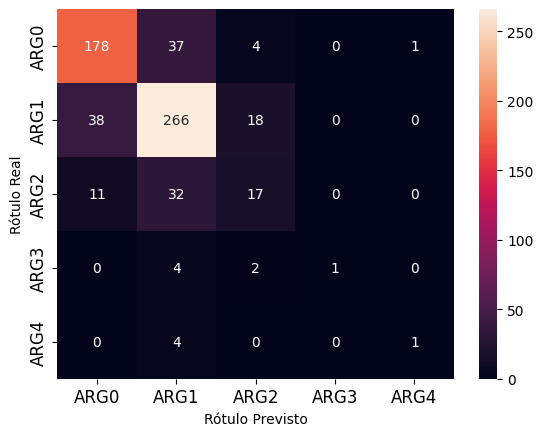

In [35]:

# Supondo que y_test e y_pred já estão definidos
cm = confusion_matrix(y_test, y_pred)

# Definir os rótulos desejados para os eixos
all_labels = [
    'ARG0', 
    'ARG1', 
    'ARG2', 
    "ARG3", 
    "ARG4"
    ]

labels = [all_labels[i] for i in range(n_classes)]

# Plotar o heatmap
ax = sns.heatmap(cm, annot=True, fmt='g')

# Definir os rótulos dos eixos
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)

# Exibir o plot
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.show()

###############################################
# corpus name: lp
###############################################
          
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       120
           1       0.80      0.83      0.81       151
           2       0.22      0.19      0.21        21
           3       1.00      0.20      0.33         5
           4       0.50      0.25      0.33         4

    accuracy                           0.79       301
   macro avg       0.68      0.47      0.51       301
weighted avg       0.78      0.79      0.78       301



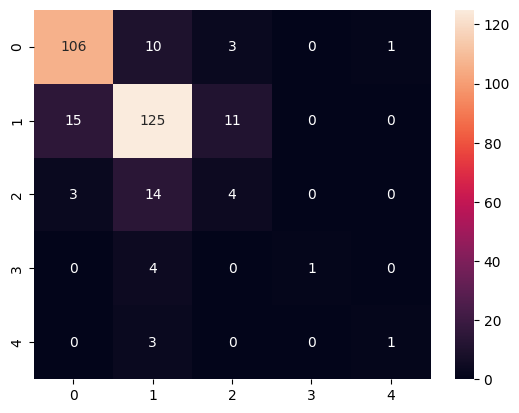

###############################################
# corpus name: news
###############################################
          
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        60
           1       0.75      0.82      0.78       115
           2       0.67      0.32      0.43        31
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.71       208
   macro avg       0.41      0.37      0.38       208
weighted avg       0.70      0.71      0.70       208



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

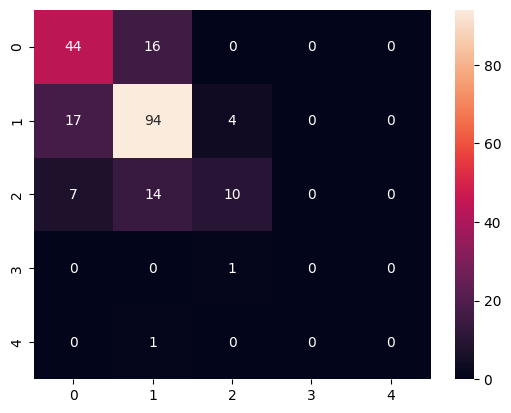

###############################################
# corpus name: opisums
###############################################
          
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        34
           1       0.72      0.84      0.77        43
           2       0.38      0.43      0.40         7
           3       0.00      0.00      0.00         1

    accuracy                           0.72        85
   macro avg       0.48      0.48      0.47        85
weighted avg       0.72      0.72      0.71        85



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

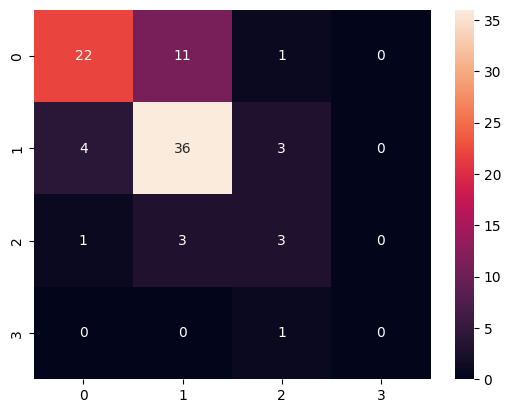

###############################################
# corpus name: sci
###############################################
          
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.92      0.85      0.88        13
           2       0.00      0.00      0.00         1

    accuracy                           0.85        20
   macro avg       0.56      0.62      0.58        20
weighted avg       0.82      0.85      0.83        20



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

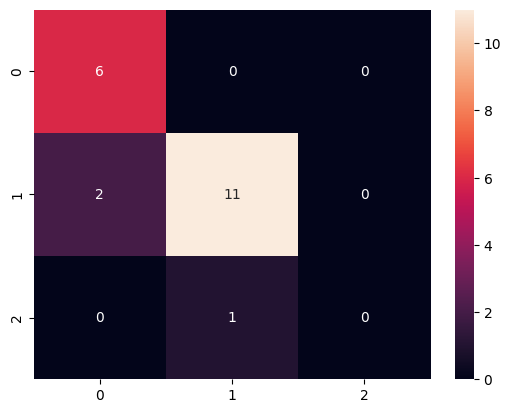

In [36]:
df_features_test = df_features.loc[y_test.index.tolist(), :]

df_anl = pd.DataFrame({
    "y_test": y_test.tolist(),
    "y_pred": y_pred.tolist(),
    "corpus_name": df_features.loc[y_test.index.tolist(), :]['corpus_name'].tolist(),  
})

for cp_nm in df_anl.corpus_name.unique():
    
    print(f"""###############################################
# corpus name: {cp_nm}
###############################################
          """)
    
    df_anl_cp = df_anl[df_anl.corpus_name == cp_nm]
    
    print(classification_report(df_anl_cp.y_test, df_anl_cp.y_pred))
    
    cm=confusion_matrix(df_anl_cp.y_test, df_anl_cp.y_pred)
    sns.heatmap(cm, annot=True, fmt='g') # font size
    plt.show()

### Featue importance

In [37]:
# # Acessar o objeto RFE na pipeline
# rfe = pipeline.named_steps['selecting']
# # Acessar o array que indica quais características foram selecionadas
# selected_features_mask = rfe.support_

selected_features_mask = model.named_steps['selecting'].get_support()

# Usar o array para filtrar os nomes das colunas do DataFrame original
selected_features = X_train.columns[selected_features_mask].tolist()

print("Características selecionadas pelo RFE:")
print(selected_features)


Características selecionadas pelo RFE:
['dep_ROOT', 'dep_advcl', 'dep_advmod', 'dep_ccomp', 'dep_conj', 'dep_iobj', 'dep_nao_tem_dep', 'dep_nsubj', 'dep_nsubj:pass', 'dep_obj', 'dep_obl', 'dep_parataxis', 'dep_xcomp', 'parent_text_,', 'parent_text_Chegamos', 'parent_text_Chegaram', 'parent_text_Confundem', 'parent_text_Da', 'parent_text_Entre', 'parent_text_Estamos', 'parent_text_Ficaram', 'parent_text_Iam', 'parent_text_Ir', 'parent_text_Li', 'parent_text_Retorna', 'parent_text_Sai', 'parent_text_Subiu', 'parent_text_Trabalhávamos', 'parent_text_Vamos', 'parent_text_Vim', 'parent_text_aberta', 'parent_text_aberto', 'parent_text_abertos', 'parent_text_aluga', 'parent_text_alugam', 'parent_text_ao', 'parent_text_apresentava', 'parent_text_assinando', 'parent_text_atuaram', 'parent_text_aumentando', 'parent_text_cair', 'parent_text_caiu', 'parent_text_caíram', 'parent_text_chega', 'parent_text_chegamos', 'parent_text_chegaram', 'parent_text_chegassem', 'parent_text_chego', 'parent_text_c

In [38]:
# forma antiga de pegar a feature original
# # Função para remover a parte após o último underscore
# def remover_apos_ultimo_underscore(s):
#     return "_".join(s.split("_")[:-1])

# original_features = [remover_apos_ultimo_underscore(feat) for feat in selected_features]

In [39]:
def get_original_feature(feature):
    
    # resolve as features embeddings
    if "emb" in feature:
        
        return re.sub(r'_\d+_', '_', feature)
    
    
    original_features = ['corpus_name', 'dep', 'parent_text',
        'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
        'child_lemma', 'child_pos', 'child_tag', 'child_ner', 'parent', 'child']
    
    for o_feat in original_features:
        
        if o_feat in feature:
            
            return o_feat
        
    return None
    

original_features = [get_original_feature(feat) for feat in selected_features]

# Extrair o modelo XGBClassifier da pipeline
xgb_model = model.named_steps['estimator']

# Obter as importâncias das características
feature_importances = xgb_model.feature_importances_

# Criar um DataFrame para facilitar a manipulação e visualização
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    "original_feature": original_features,
    'importance': feature_importances
})

In [40]:
for idx, row in feature_importance_df.iterrows():
    
    print(row.feature,"|", row.original_feature)

dep_ROOT | dep
dep_advcl | dep
dep_advmod | dep
dep_ccomp | dep
dep_conj | dep
dep_iobj | dep
dep_nao_tem_dep | dep
dep_nsubj | dep
dep_nsubj:pass | dep
dep_obj | dep
dep_obl | dep
dep_parataxis | dep
dep_xcomp | dep
parent_text_, | parent_text
parent_text_Chegamos | parent_text
parent_text_Chegaram | parent_text
parent_text_Confundem | parent_text
parent_text_Da | parent_text
parent_text_Entre | parent_text
parent_text_Estamos | parent_text
parent_text_Ficaram | parent_text
parent_text_Iam | parent_text
parent_text_Ir | parent_text
parent_text_Li | parent_text
parent_text_Retorna | parent_text
parent_text_Sai | parent_text
parent_text_Subiu | parent_text
parent_text_Trabalhávamos | parent_text
parent_text_Vamos | parent_text
parent_text_Vim | parent_text
parent_text_aberta | parent_text
parent_text_aberto | parent_text
parent_text_abertos | parent_text
parent_text_aluga | parent_text
parent_text_alugam | parent_text
parent_text_ao | parent_text
parent_text_apresentava | parent_text
pa

In [41]:
feature_importance_df.original_feature.value_counts()

original_feature
emb_lemma_child     300
emb_lemma_parent    300
parent_text         158
child_text           90
dep                  13
child_pos            10
child_tag            10
child_ner             5
parent_pos            3
parent_tag            3
Name: count, dtype: int64

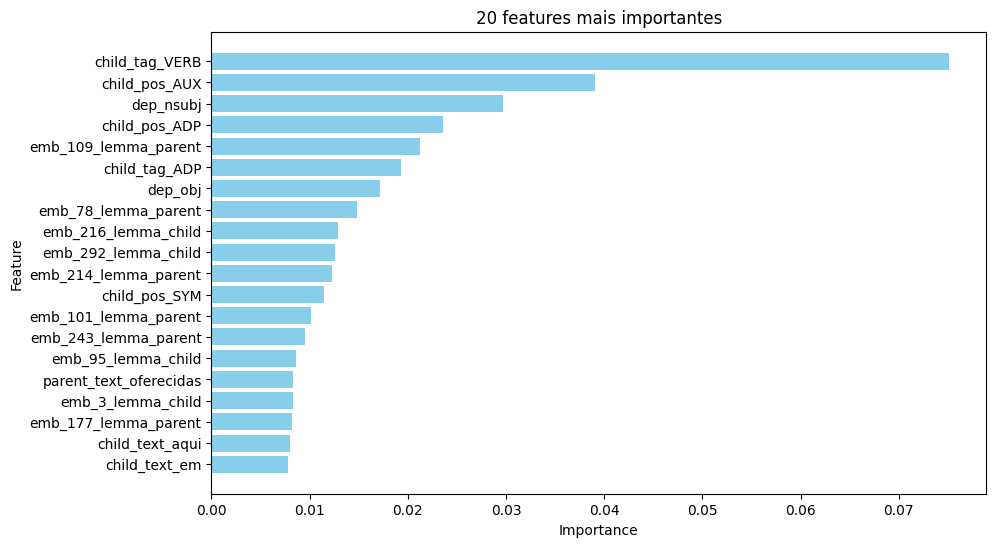

In [53]:
# Ordenar o DataFrame pelo valor de importância
top_n = 20
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(top_n)

# Plotar o gráfico de barras das principais características
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'{top_n} features mais importantes')
plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar a característica mais importante no topo
plt.show()


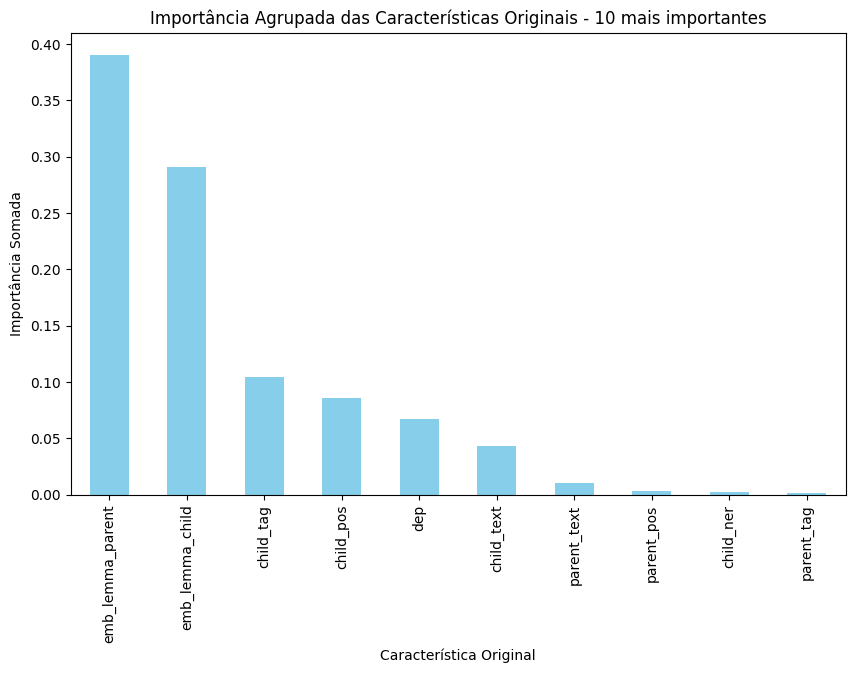

In [54]:
grouped_importances = feature_importance_df.groupby('original_feature')['importance'].sum().sort_values(ascending=False)
# Plotar o gráfico das características originais mais importantes
plt.figure(figsize=(10, 6))
top_n = 10
grouped_importances.head(top_n).plot(kind='bar', color='skyblue')
plt.title(f'Importância Agrupada das Características Originais - {top_n} mais importantes')
plt.xlabel('Característica Original')
plt.ylabel('Importância Somada')
plt.show()

### SHAP

In [44]:
X_enc

,dep_ROOT,dep_acl,dep_acl:relcl,dep_advcl,dep_advmod,dep_amod,dep_appos,dep_aux,dep_aux:pass,dep_case,...,emb_291_lemma_parent,emb_292_lemma_parent,emb_293_lemma_parent,emb_294_lemma_parent,emb_295_lemma_parent,emb_296_lemma_parent,emb_297_lemma_parent,emb_298_lemma_parent,emb_299_lemma_parent,emb_300_lemma_parent
0,False,False,False,False,False,False,False,False,False,False,...,0.278671,-0.404273,-0.119715,0.235350,0.216640,0.011861,-0.049042,0.000335,-0.080059,0.139830
1,False,False,False,False,False,False,False,False,False,False,...,0.032014,-0.141032,0.110290,0.012083,-0.007258,-0.004613,-0.014778,0.023993,-0.205071,0.068340
2,False,False,False,False,False,False,False,False,False,False,...,0.032014,-0.141032,0.110290,0.012083,-0.007258,-0.004613,-0.014778,0.023993,-0.205071,0.068340
3,False,False,False,False,False,False,False,False,False,False,...,-0.162917,0.019949,0.347596,0.259526,-0.094135,-0.018389,-0.020401,0.233729,-0.158561,0.206836
4,False,False,False,False,False,False,False,False,False,False,...,0.170762,-0.134321,0.021434,-0.017953,0.132761,0.223882,-0.270413,0.093207,-0.143554,-0.072965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,False,False,False,False,False,False,False,False,False,False,...,-0.093402,-0.325779,0.160753,0.393574,0.085029,0.115601,0.053970,0.015961,-0.180026,-0.035891
13242,True,False,False,False,False,False,False,False,False,False,...,-0.093402,-0.325779,0.160753,0.393574,0.085029,0.115601,0.053970,0.015961,-0.180026,-0.035891
13243,False,False,False,False,False,False,False,False,False,False,...,0.087175,-0.100272,-0.090553,-0.060146,-0.013218,0.054579,0.101700,-0.021893,-0.014914,0.247532
13244,False,False,False,False,False,False,False,False,False,False,...,0.087175,-0.100272,-0.090553,-0.060146,-0.013218,0.054579,0.101700,-0.021893,-0.014914,0.247532


In [45]:
X_enc

,dep_ROOT,dep_acl,dep_acl:relcl,dep_advcl,dep_advmod,dep_amod,dep_appos,dep_aux,dep_aux:pass,dep_case,...,emb_291_lemma_parent,emb_292_lemma_parent,emb_293_lemma_parent,emb_294_lemma_parent,emb_295_lemma_parent,emb_296_lemma_parent,emb_297_lemma_parent,emb_298_lemma_parent,emb_299_lemma_parent,emb_300_lemma_parent
0,False,False,False,False,False,False,False,False,False,False,...,0.278671,-0.404273,-0.119715,0.235350,0.216640,0.011861,-0.049042,0.000335,-0.080059,0.139830
1,False,False,False,False,False,False,False,False,False,False,...,0.032014,-0.141032,0.110290,0.012083,-0.007258,-0.004613,-0.014778,0.023993,-0.205071,0.068340
2,False,False,False,False,False,False,False,False,False,False,...,0.032014,-0.141032,0.110290,0.012083,-0.007258,-0.004613,-0.014778,0.023993,-0.205071,0.068340
3,False,False,False,False,False,False,False,False,False,False,...,-0.162917,0.019949,0.347596,0.259526,-0.094135,-0.018389,-0.020401,0.233729,-0.158561,0.206836
4,False,False,False,False,False,False,False,False,False,False,...,0.170762,-0.134321,0.021434,-0.017953,0.132761,0.223882,-0.270413,0.093207,-0.143554,-0.072965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,False,False,False,False,False,False,False,False,False,False,...,-0.093402,-0.325779,0.160753,0.393574,0.085029,0.115601,0.053970,0.015961,-0.180026,-0.035891
13242,True,False,False,False,False,False,False,False,False,False,...,-0.093402,-0.325779,0.160753,0.393574,0.085029,0.115601,0.053970,0.015961,-0.180026,-0.035891
13243,False,False,False,False,False,False,False,False,False,False,...,0.087175,-0.100272,-0.090553,-0.060146,-0.013218,0.054579,0.101700,-0.021893,-0.014914,0.247532
13244,False,False,False,False,False,False,False,False,False,False,...,0.087175,-0.100272,-0.090553,-0.060146,-0.013218,0.054579,0.101700,-0.021893,-0.014914,0.247532


In [46]:
X_enc.shape[1] - len(features_std_0)

8918

In [47]:
X_all = X_enc.drop(features_std_0, axis = 1)

In [48]:
# 1. Carregar o modelo treinado do pipeline
xgb_model = model.named_steps['estimator']

for step in [step[0] for step in model.steps if step[0] != "estimator"]:
    
    print(step)
    
    if step == "sampling":
        pass
    else:
        X_test_processed = model[step].transform(X_test)
        X_train_processed = model[step].transform(X_train)
        X_all_processed = model[step].transform(X_all)
        
        
df_X_test_anl = pd.DataFrame(X_test_processed, columns = selected_features)
df_X_train_anl = pd.DataFrame(X_train_processed, columns = selected_features)
df_X_all_anl = pd.DataFrame(X_all_processed, columns = selected_features)

scaling
selecting


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectPercentile was fitted without feature names
  warnings.warn(
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectPercentile was fitted without feature names
  warnings.warn(
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectPercentile was fitted without feature names
  warnings.warn(


sampling


#### Tree explainer

In [49]:
# 2. Criar o objeto Explainer para o modelo XGB
explainer = shap.TreeExplainer(xgb_model)

# 3. Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(df_X_all_anl)
shap_values.shape

(13245, 892, 5)

0


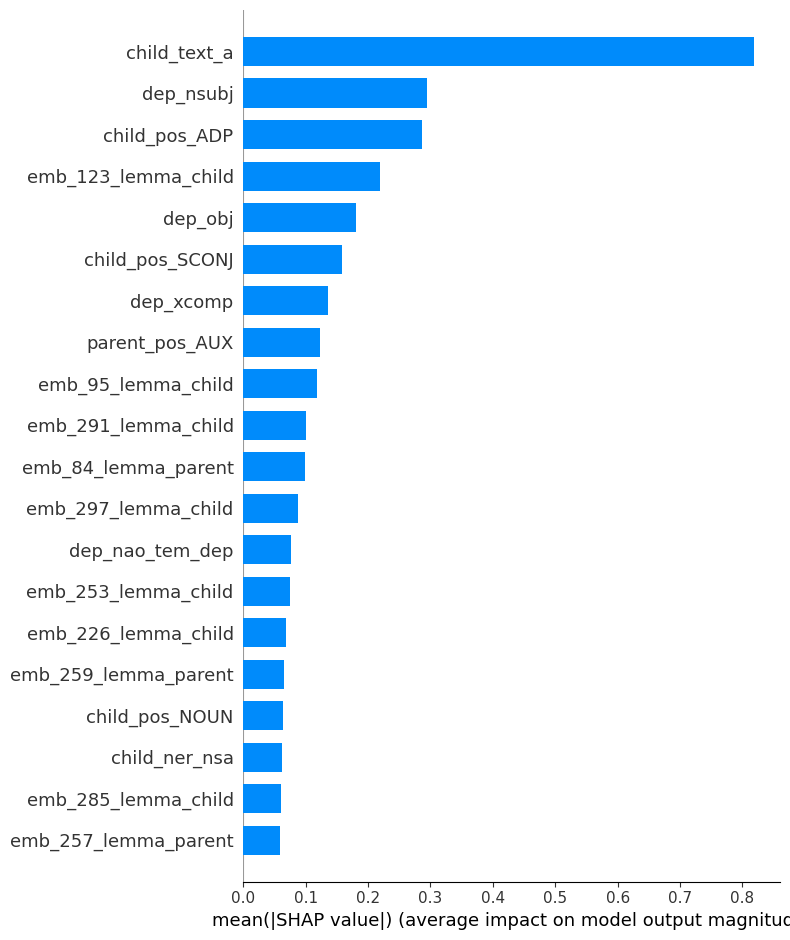

1


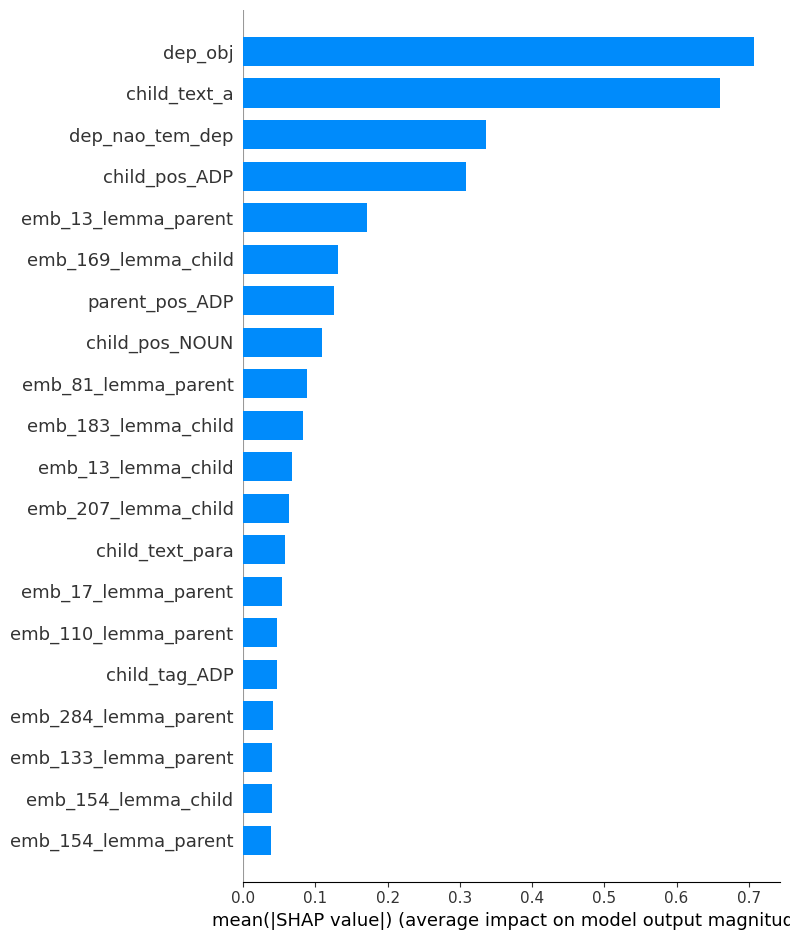

2


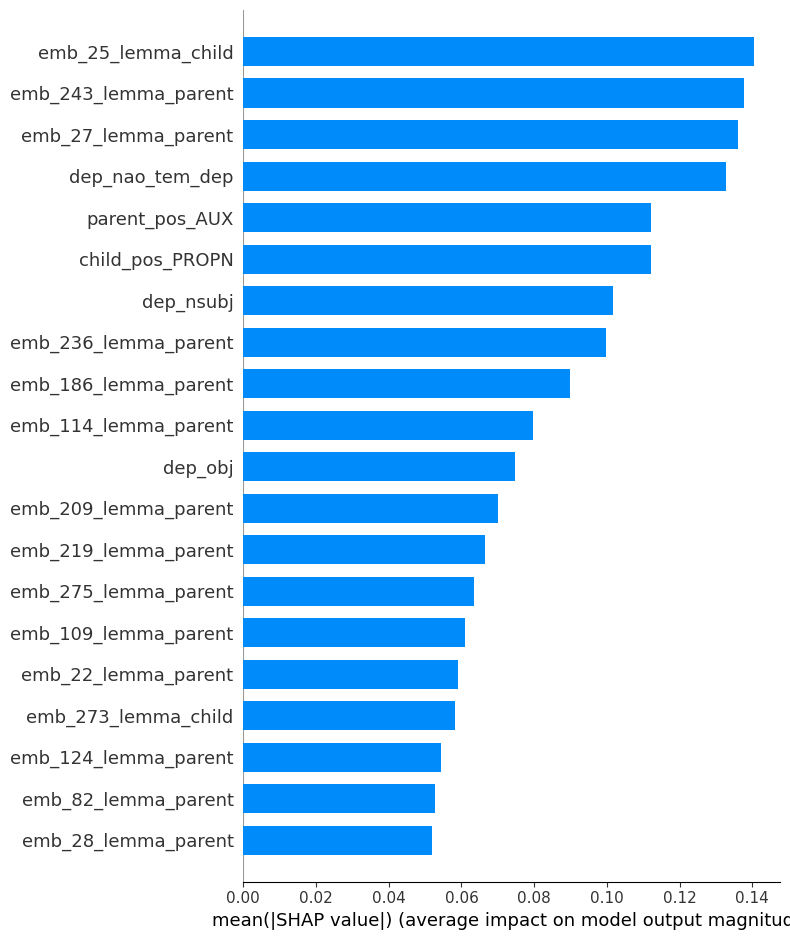

3


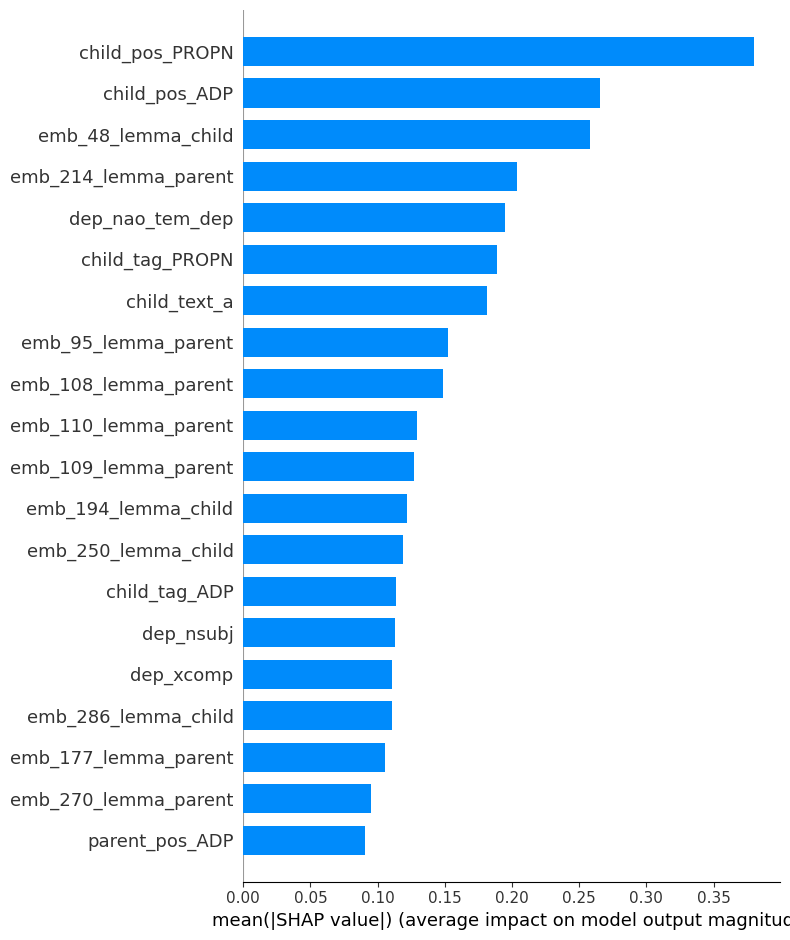

4


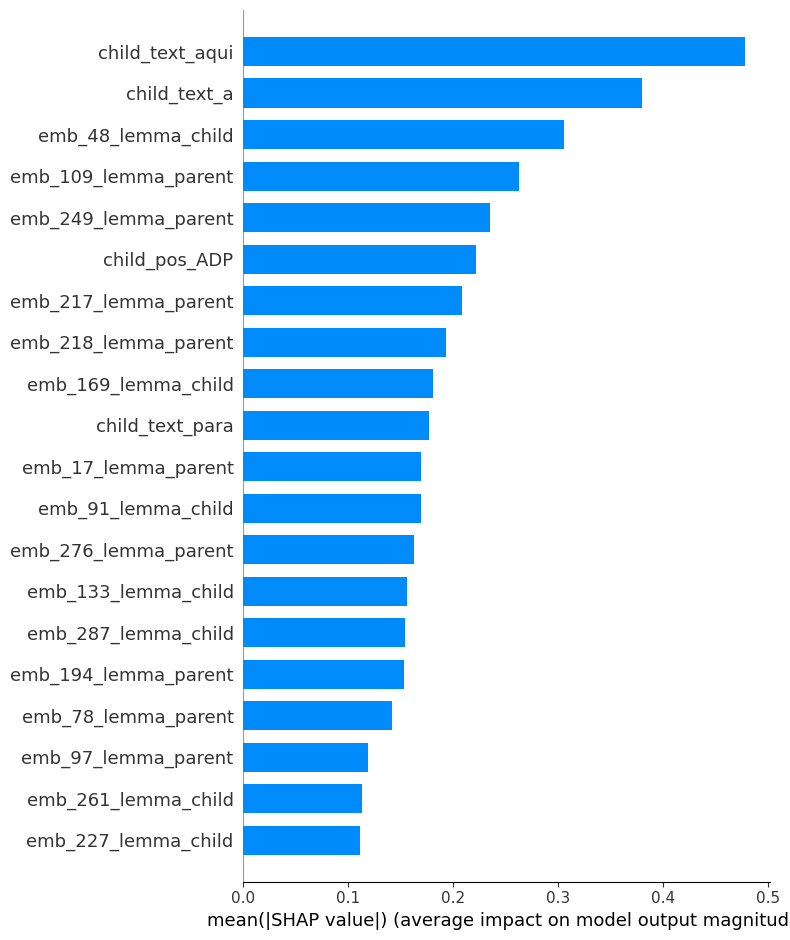

In [50]:
for c in range(n_classes):
    
    print(c)
    
    shap.summary_plot(shap_values[:, :, c],df_X_all_anl , plot_type="bar")
    

0


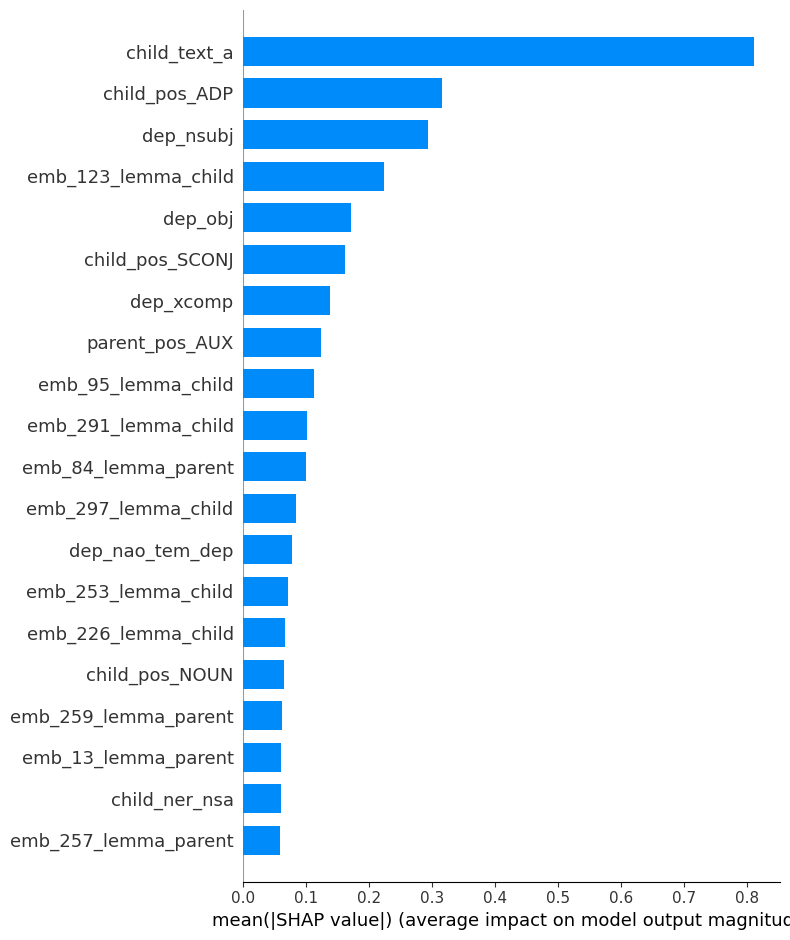

1


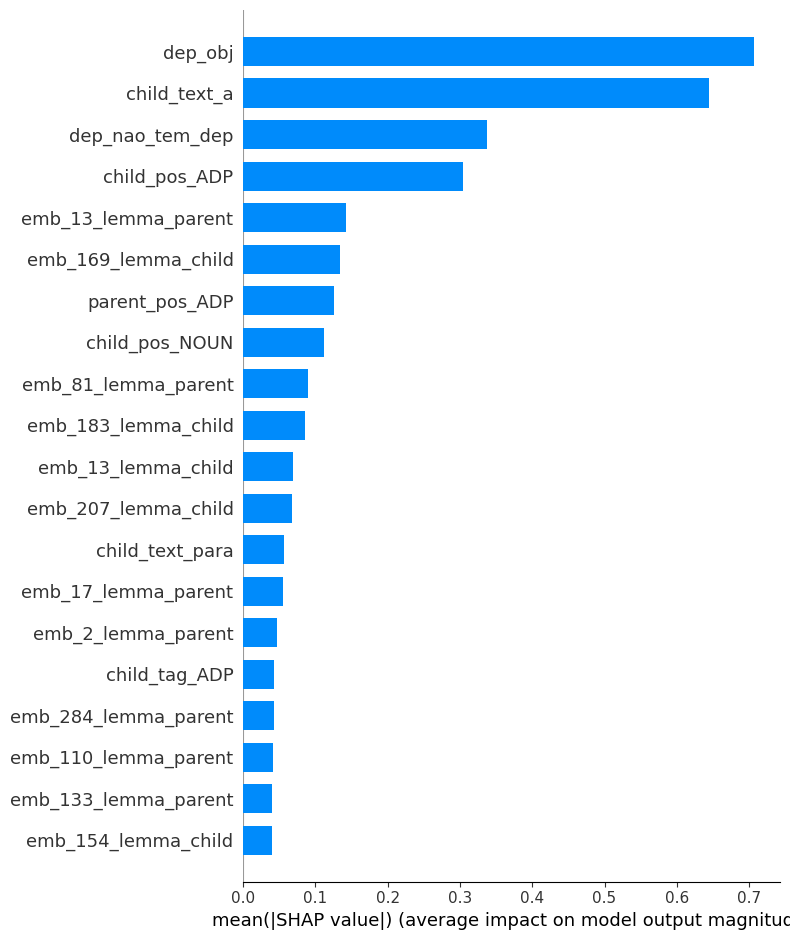

2


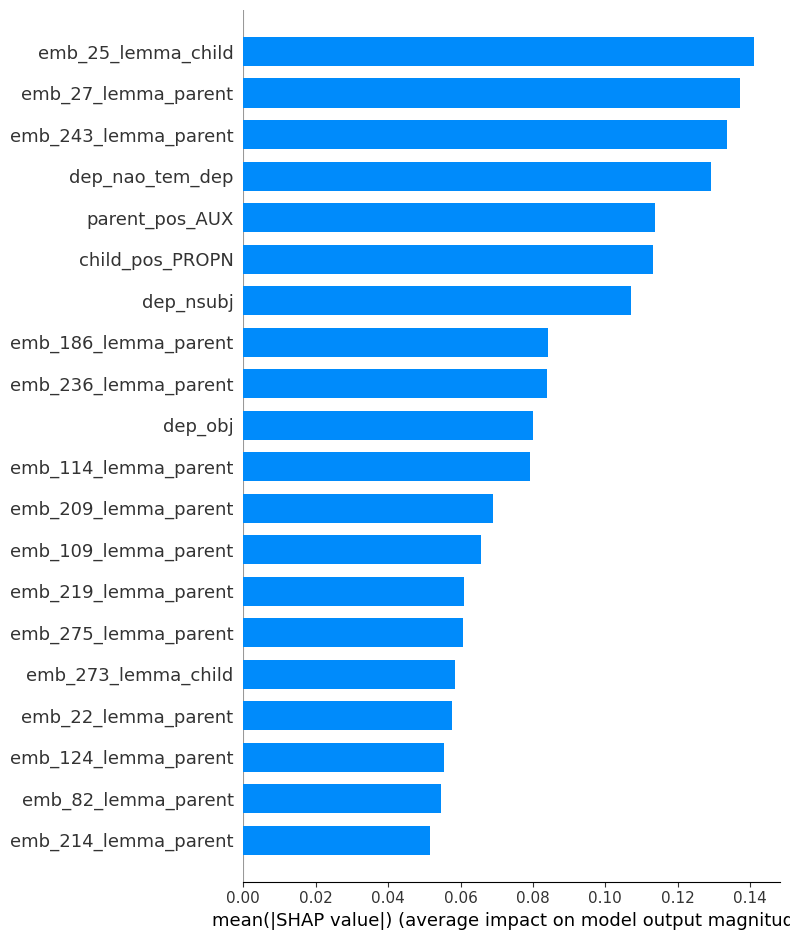

3


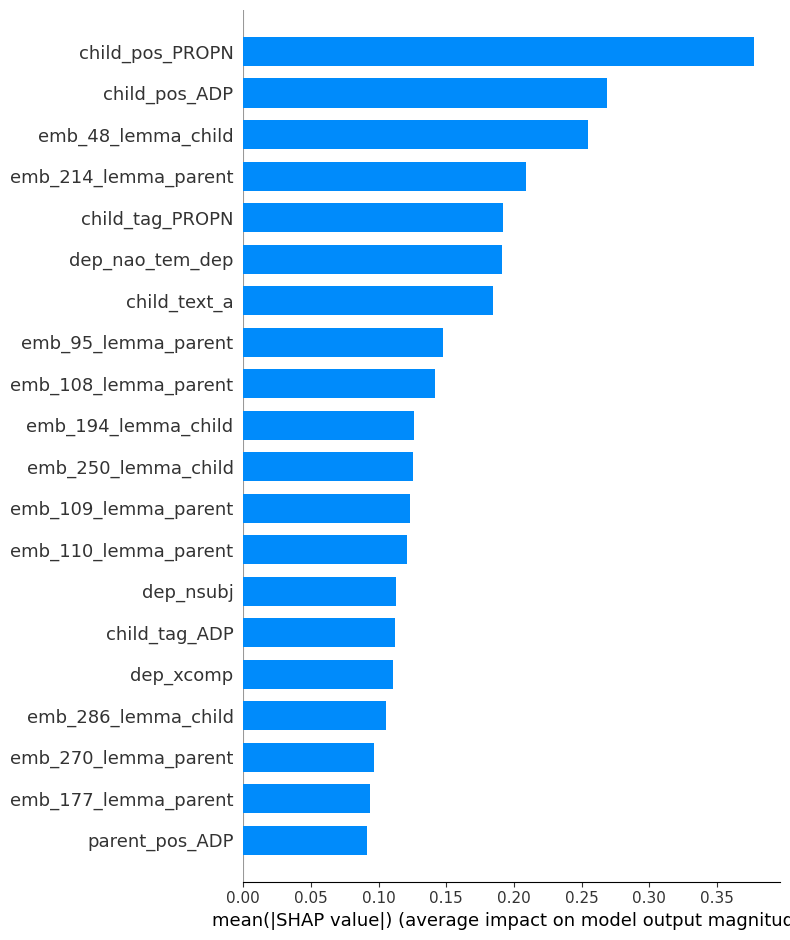

4


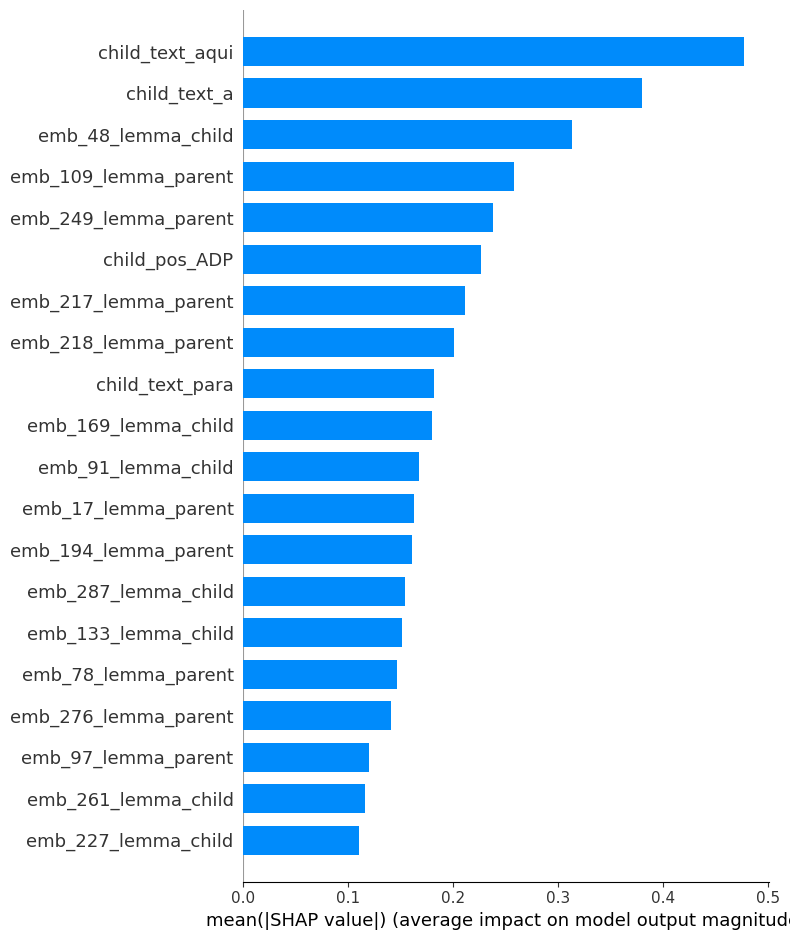

In [57]:
# 3. Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(df_X_test_anl)


for c in range(n_classes):
    
    print(c)
    
    shap.summary_plot(shap_values[:, :, c],df_X_test_anl , plot_type="bar")
    